### Quora competition
Автор: Гусев Илья


In [51]:
import csv
import os
import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from keras.models import Model, load_model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from keras.layers import LSTM, Bidirectional, Dropout, Dense, Input, Embedding, BatchNormalization
from keras.layers.merge import concatenate
from gensim.models import KeyedVectors

TRAIN_DATA_PATH = os.path.join(os.getcwd(), "data", "train.csv")
TEST_DATA_PATH = os.path.join(os.getcwd(), "data", "test.csv")
VOCABULARY_PATH = os.path.join(os.getcwd(), "models", "vocabulary.pickle")

In [52]:
class Vocabulary(object):
    """
    Индексированный словарь.
    """
    def __init__(self, dump_filename):
        self.dump_filename = dump_filename
        self.reset()

        if os.path.isfile(self.dump_filename):
            self.load()

    def save(self) -> None:
        with open(self.dump_filename, "wb") as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    def load(self):
        with open(self.dump_filename, "rb") as f:
            vocab = pickle.load(f)
            self.__dict__.update(vocab.__dict__)

    def add_word(self, word):
        if self.word_to_index.get(word) is None:
            self.index_to_word.append(word)
            index = len(self.index_to_word) -1
            self.word_to_index[word] = index
            return index
        return self.word_to_index[word]
    
    def count_word(self, word):
        self.counter[word] += 1

    def get_word_index(self, word) -> int:
        if self.word_to_index.get(word) is not None:
            return self.word_to_index[word]
        return -1

    def get_word(self, index):
        return self.index_to_word[index]

    def size(self):
        return len(self.index_to_word)
    
    def reset(self):
        self.word_to_index = {}
        self.index_to_word = []
        self.counter = Counter()
        self.word_to_index["NotAWord"] = 0
        self.index_to_word.append("NotAWord")
        self.counter["NotAWord"] = 1
    
    def shrink(self, num):
        pairs = self.counter.most_common(num)
        self.reset()
        for word, count in pairs:
            self.add_word(word)

In [53]:
class DataManager:
    def __init__(self, train_data_path, test_data_path):
        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        self.x_train_raw = ([], [])
        self.x_train = ([], [])
        self.x_test_raw = ([], [])
        self.x_test = ([], [])
        self.y_train = []
        self.feature_transformer = preprocessing.StandardScaler()
        
    def load_train_data(self, vocabulary, vocabulary_only=False, save_raw=True):
        with open(self.train_data_path, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter=',')
            header = next(reader)
            for values in reader:
                q1 = values[3]
                q2 = values[4]
                if vocabulary_only:
                    DataManager.__prepare_data(q1, vocabulary, skip_new_words=False)
                    DataManager.__prepare_data(q2, vocabulary, skip_new_words=False)
                    continue
                if save_raw:
                    self.x_train_raw[0].append(q1)
                    self.x_train_raw[1].append(q2)
                self.x_train[0].append(DataManager.__prepare_data(q1, vocabulary, skip_new_words=True))
                self.x_train[1].append(DataManager.__prepare_data(q2, vocabulary, skip_new_words=True))
                self.y_train.append(int(values[5]))
            if not vocabulary_only:
                self.x_train = (np.array(self.x_train[0]), np.array(self.x_train[1]))
     
    def load_test_data(self, vocabulary, vocabulary_only=False, save_raw=True):
        with open(self.test_data_path, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter=',')
            header = next(reader)
            for values in reader:
                q1 = values[1]
                q2 = values[2]
                if vocabulary_only:
                    DataManager.__prepare_data(q1, vocabulary, skip_new_words=False)
                    DataManager.__prepare_data(q2, vocabulary, skip_new_words=False)
                    continue
                if save_raw:
                    self.x_test_raw[0].append(q1)
                    self.x_test_raw[1].append(q2)
                self.x_test[0].append(DataManager.__prepare_data(q1, vocabulary, skip_new_words=True))
                self.x_test[1].append(DataManager.__prepare_data(q2, vocabulary, skip_new_words=True))
            if not vocabulary_only:
                self.x_test = (np.array(self.x_test[0]), np.array(self.x_test[1]))      
                
    def collect_features(self, is_train):
        features = []
        if is_train:
            x = self.x_train
            x_raw = self.x_train_raw
        else:
            x = self.x_test
            x_raw = self.x_test_raw
        words = (" ".join(x_raw[0] + x_raw[1])).lower().split()
        counts = Counter(words)
        def get_weight(count, eps=10000, min_count=2):
            return 0 if count < min_count else 1 / (count + eps)
        weights = {word: get_weight(count) for word, count in counts.items()}
        stops = set(stopwords.words("english"))
        for i in range(len(x[0])):
            q1 = x_raw[0][i]
            q2 = x_raw[1][i]
            q1_words = set(q1.lower().split())
            q1_words = q1_words.difference(stops)
            if len(q1_words) == 0:
                features.append(np.zeros(19,))
                continue

            q2_words = set(q2.lower().split())
            q2_words = q2_words.difference(stops)
            if len(q2_words) == 0:
                features.append(np.zeros(19,))
                continue

            q1_stops = q1_words.intersection(stops)
            q2_stops = q2_words.intersection(stops)

            shared_words = q1_words.intersection(q2_words)
            shared_weights = [weights.get(w, 0) for w in shared_words]
            total_weights = [weights.get(w, 0) for w in q1_words] + [weights.get(w, 0) for w in q2_words]
            
            len_char_q1 = len(q1.replace(' ', ''))
            len_char_q2 = len(q2.replace(' ', ''))
            len_word_q1 = len(q1.split())
            len_word_q2 = len(q2.split())
                                
            feature = []
            feature.append(np.sum(shared_weights)/np.sum(total_weights) if abs(np.sum(total_weights)) < 0.00001  else 0.0)
            feature.append(len(shared_words)/(len(q1_words)+len(q2_words)))
            feature.append(len(q1_stops)/len(q1_words))
            feature.append(len(q2_stops)/len(q2_words))
            feature.append(len(q1_stops)/len(q1_words)-len(q2_stops)/len(q2_words))
            feature.append(len(shared_words))
            feature.append(len(q1))
            feature.append(len(q1))
            feature.append(len(q1)-len(q2))
            feature.append(len_char_q1)
            feature.append(len_char_q2)
            feature.append(len_char_q1-len_char_q2)
            feature.append(len_word_q1)
            feature.append(len_word_q2)
            feature.append(len_word_q1-len_word_q2)
            feature.append(len_char_q1/len_word_q1)
            feature.append(len_char_q2/len_word_q2)
            feature.append(len_char_q1/len_word_q1-len_char_q2/len_word_q2)
            feature.append(int(q1 == q2))
            features.append(np.array(feature))
        features = np.array(features)
        features = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0).fit_transform(features)
        if is_train:
            features = self.feature_transformer.fit_transform(features)
        else:
            features = self.feature_transformer.transform(features)
        return features
                    
    def explain_train_data(self):
        """
        Различные метрики данных.
        https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-quora-ques-pair
        """
        for i in range(5):
            print(self.x_train_raw[0][i])
            print(DataManager.__clean_data(self.x_train_raw[0][i]))
            print(self.x_train[0][i])
        
        df = pd.DataFrame(self.x_train_raw[0]+self.x_train_raw[1])
        df.columns = ["questions"]
        df["num_of_words"] = df["questions"].apply(lambda x : len(DataManager.__clean_data(x).split()))
        counts = df['num_of_words'].value_counts()
        plt.figure(figsize=(12,6))
        sns.barplot(counts.index, counts.values, alpha=0.8, color=sns.color_palette()[0])
        plt.ylabel('Number of occurrences', fontsize=12)
        plt.xlabel('Number of words in the question', fontsize=12)
        plt.xticks(rotation='vertical')
        plt.show()
        
        df = pd.DataFrame(self.y_train)
        df.columns = ['is_duplicate']
        is_dup = df['is_duplicate'].value_counts()
        plt.figure(figsize=(8,4))
        sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=sns.color_palette()[1])
        plt.ylabel('Number of Occurrences', fontsize=12)
        plt.xlabel('Is Duplicate', fontsize=12)
        plt.show()

    @staticmethod
    def __prepare_data(text, vocabulary, skip_new_words=False, stemming=False, removing_stopwords=False):
        """
        Подготовка данных.
        
        :param text: текст, который нужно преобразовать в последовательность индексов.
        :return: последовательность индексов.
        """
        text = DataManager.__clean_data(text)
        if removing_stopwords:
            text = DataManager.__remove_stopwords(text)
        if stemming:
            text = DataManager.__stem(text)
        indices = []
        for word in text.split():
            vocabulary.count_word(word)
            word_index = vocabulary.get_word_index(word)
            if word_index == -1:
                if not skip_new_words:
                    word_index = vocabulary.add_word(word)
                else:
                    word_index = vocabulary.size()
            indices.append(word_index)
        return np.array(indices, dtype="int32")
           
    @staticmethod
    def __clean_data(text):
        """
        Очистка текста. Взято из https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text.
        
        :param text: текст, который нужно очистить.
        :return: очищенный текст.
        """
        text = text.lower().split()
        text = " ".join(text)
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\^", " ^ ", text)
        text = re.sub(r"\+", " + ", text)
        text = re.sub(r"\-", " - ", text)
        text = re.sub(r"\=", " = ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r" u s ", " american ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e - mail", "email", text)
        text = re.sub(r"j k", "jk", text)
        text = re.sub(r"\s{2,}", " ", text)
        return text
    
    @staticmethod
    def __stem(text):
        """
        Стемминг слов.
        
        :param text: текст, содержаший слова, основы которых нужно найти.
        :return: текст из основ.
        """
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
        return text
    
    @staticmethod
    def __remove_stopwords(text):
        """
        Удаление стоп-слов.
        
        :param text: текст, содержащий стоп-слова.
        :return: текст без стоп-слов.
        """

        text = text.split()
        stops = set(stopwords.words("english"))
        filtered_words = [w for w in text if not w in stops]
        text = " ".join(filtered_words)
        return text

In [54]:
def load_w2v(embeddings_filename, embeddings_type="glove"):
    if embeddings_type == "w2v":
        w2v = KeyedVectors.load_word2vec_format(embeddings_filename, binary=True)
    elif embeddings_type == "glove":
        with open(embeddings_filename, "r", encoding="utf-8") as lines:
            w2v = dict()
            for line in lines:
                try:
                    w2v[line.split()[0]] = np.array(list(map(float, line.split()[1:])))
                except ValueError:
                    continue
    return w2v

def shrink_vocabulary(vocabulary, w2v, embeddings_type):
    filename = os.path.join(os.getcwd(), "models", "vocabulary_"+embeddings_type+".pickle")
    clean_vocabulary = Vocabulary(filename)
    if clean_vocabulary.size() <= 1:
        for word in vocabulary.word_to_index.keys():
            if embeddings_type == "glove" and w2v.get(word) is not None or embeddings_type == "w2v" and word in w2v.vocab:
                clean_vocabulary.add_word(word)
        clean_vocabulary.save()
    return clean_vocabulary


def get_weights(w2v, embedding_dim, vocabulary, embeddings_type="glove"):
    weights = np.random.uniform(low=-0.1, high=0.1, size=(vocabulary.size() + 1, embedding_dim))
    weights[0] = np.zeros((embedding_dim))
    for i, word in enumerate(vocabulary.index_to_word):
        if embeddings_type == "glove" and w2v.get(word) is not None:
            weights[i] = w2v[word]
        elif embeddings_type == "w2v" and word in w2v.vocab:
            weights[i] = w2v.word_vec(word)
    return weights


# Собрать словарь
def compose_vocab(embeddings_name, embeddings_type, embeddings_dim, unite_unknown_words=False):
    embeddings_filename = os.path.join(os.getcwd(), "resources", embeddings_name)
    vocabulary = Vocabulary(VOCABULARY_PATH)
    if vocabulary.size() <= 1:
        data = DataManager(TRAIN_DATA_PATH, TEST_DATA_PATH)
        data.load_train_data(vocabulary, vocabulary_only=True)
        print("Train vocab size: " + str(vocabulary.size()))
        data.load_test_data(vocabulary, vocabulary_only=True)
        print("Train+test vocab size: " + str(vocabulary.size()))
        vocabulary.save()
    print("Data vocab size: " + str(vocabulary.size()))
    
    w2v = load_w2v(embeddings_filename, embeddings_type=embeddings_type)
    if unite_unknown_words:
        vocabulary = shrink_vocabulary(vocabulary, w2v, embeddings_type=embeddings_type)
        print("Shrinked vocab size: " + str(vocabulary.size()))
    
    weights = get_weights(w2v, embeddings_dim, vocabulary, embeddings_type=embeddings_type)
    return vocabulary, weights

# vocabulary, weights = compose_vocab("glove.840B.300d.txt", "glove", 300)
vocabulary, weights = compose_vocab("GoogleNews-vectors-negative300.bin.gz", "w2v", 300)

Data vocab size: 121326


What is the step by step guide to invest in share market in india?
what is the step by step guide to invest in share market in india 
[ 1  2  3  4  5  4  6  7  8  9 10 11  9 12]
What is the story of Kohinoor (Koh-i-Noor) Diamond?
what is the story of kohinoor koh - i - noor diamond 
[ 1  2  3 13 14 15 16 17 18 17 19 20]
How can I increase the speed of my internet connection while using a VPN?
how can i increase the speed of my internet connection while using a vpn 
[28 29 18 30  3 31 14 32 33 34 35 36 37 38]
Why am I mentally very lonely? How can I solve it?
why am i mentally very lonely how can i solve it 
[44 45 18 46 47 48 28 29 18 49 50]
Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
which one dissolve in water quikly sugar salt methane and carbon di oxide 
[59 60 61  9 62 63 64 65 66 67 68 69 70]


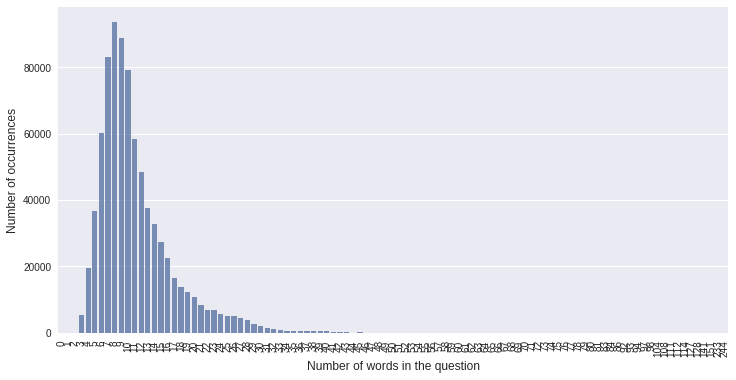

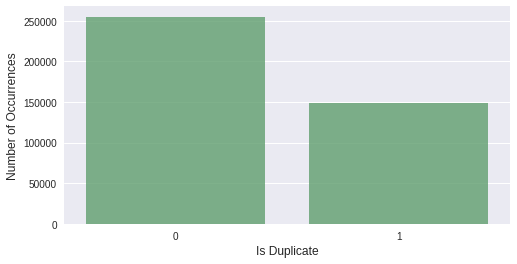

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars


[ 0.          1.11708291  0.          0.          0.          1.08378212
  0.21588014  0.21588014  0.29387761  0.13750497 -0.14101934  0.27401292
  0.56325471  0.12981472  0.3684335  -0.95465355 -0.84414894 -0.13511875
  0.        ]


In [55]:
# Загрузить обучающую выборку
data = DataManager(TRAIN_DATA_PATH, TEST_DATA_PATH)
data.load_train_data(vocabulary, vocabulary_only=False)
data.explain_train_data()
x_train_add = data.collect_features(is_train=True)
print(x_train_add[0])

In [56]:
class QuoraRNN:
    def __init__(self, word_max_count=30, rnn=LSTM, units1=256, units2=128, dropout=0.3, batch_size=2048):
        self.rnn = rnn
        self.dropout = dropout
        self.units1 = units1
        self.units2 = units2
        self.word_max_count = word_max_count
        self.batch_size = batch_size
        self.model = None

    def build(self, weights, n_additional_features=0) -> None:
        """
        Построение модели.
        """
        emb = Embedding(weights.shape[0], weights.shape[1], weights=[weights, ], trainable=False)
        inp1 = Input(shape=(self.word_max_count,), dtype='int32')
        inp2 = Input(shape=(self.word_max_count,), dtype='int32')
        inp3 = Input(shape=(n_additional_features,), dtype='float32', name='add_input')
        
        emb1 = emb(inp1)
        emb2 = emb(inp2)
        
        lstm_layer = Bidirectional(self.rnn(self.units1, recurrent_dropout=self.dropout))
        encoded = concatenate([lstm_layer(emb1), lstm_layer(emb2)])
        merged = Dropout(self.dropout)(encoded)
        
        dense1 = Dense(self.units2, activation='relu')(merged)
        dense1 = Dropout(self.dropout)(dense1)
        merged = concatenate([dense1, inp3])
        
        dense2 = Dense(self.units2, activation='relu')(merged)
        dense2 = Dropout(self.dropout)(dense2)
        
        predictions = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inp1, inp2, inp3], outputs=predictions)
        model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
        print(model.summary())
        self.model = model

    def train(self, x, x_add, y, enable_checkpoints=True, checkpoint=None, re_weight=True, val_part=0.1) -> None:
        """
        Обучение модели.
        
        :param x: индексы слов.
        :param y: is_duplicate.
        :param vocabulary: словарь.
        :param dir_name: папка с версиями модели.
        :param enable_checkpoints: использовать ли чекпоинты.
        :param checkpoint: загрузка чекпоинта.
        """
        filename = "{rnn}{units1}_{rnn}{units2}_dropout{dropout}.h5"
        filename = filename.format(rnn=self.rnn.__name__, units1=self.units1, units2=self.units2, dropout=self.dropout)
        filename = os.path.join(os.getcwd(), "models", filename)
        
        x = (sequence.pad_sequences(x[0], maxlen=self.word_max_count),
             sequence.pad_sequences(x[1], maxlen=self.word_max_count))
        y = np.array(y)
        x_add = np.array(x_add, dtype='float32')
        
        # Деление на выборки.
        np.random.seed(42)
        perm = np.random.permutation(len(x[0]))
        idx_train = perm[:int(len(x[0])*(1-val_part))]
        idx_val = perm[int(len(x[0])*(1-val_part)):]

        x_train_0 = np.vstack((x[0][idx_train], x[1][idx_train]))
        x_train_1 = np.vstack((x[1][idx_train], x[0][idx_train]))
        x_train_add = np.vstack((x_add[idx_train], x_add[idx_train]))
        y_train = np.concatenate((y[idx_train], y[idx_train]))
        print("Train example:")
        print(x_train_0[0], x_train_1[0], y_train[0])

        x_val_0 = np.vstack((x[0][idx_val], x[1][idx_val]))
        x_val_1 = np.vstack((x[1][idx_val], x[0][idx_val]))
        x_val_add = np.vstack((x_add[idx_val], x_add[idx_val]))
        y_val = np.concatenate((y[idx_val], y[idx_val]))
        print("Val example:")
        print(x_val_0[0], x_val_1[0], y_val[0])
        
        x_all_0 = np.vstack((x[0], x[1]))
        x_all_1 = np.vstack((x[1], x[0]))
        x_all_add = np.vstack((x_add, x_add))
        y_all = np.concatenate((y, y))
        print("All example:")
        print(x_all_0[0], x_all_1[0], y_all[0])
        
        # Основные раунды обучения.
        callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
        if enable_checkpoints:
            callbacks.append(ModelCheckpoint(filename, monitor='val_loss', save_best_only=True))
        if checkpoint is not None:
            self.load(checkpoint)
        
        # Перевзвешиваем, учитывая что в етстовой выборке ~17% дубликатов.
        weight_val = np.ones(len(y_val))
        class_weight = {0: 1.0, 1: 1.0}
        if re_weight:
            weight_val *= 0.472001959
            for i in range(len(y_val)):
                if y_val[i] == 0:
                    weight_val[i] = 1.309028344
            class_weight = {0: 1.309028344, 1: 0.472001959}
            
        self.model.fit([x_train_0, x_train_1, x_train_add], y_train, 
                       validation_data=([x_val_0, x_val_1, x_val_add], y_val, weight_val),
                       epochs=40,
                       batch_size=self.batch_size,
                       shuffle=True, 
                       callbacks=callbacks, 
                       class_weight=class_weight,
                       verbose=1)
        
        # Один раунд обучения на всём датасете.
        if enable_checkpoints:
            self.load(filename)
        self.model.fit([x_all_0, x_all_1, x_all_add], y_all,
                       epochs=1, 
                       batch_size=self.batch_size, 
                       shuffle=True, 
                       class_weight=class_weight,
                       verbose=1)
        self.model.save(filename)

    def load(self, filename: str) -> None:
        self.model = load_model(filename)

    def predict(self, x, x_add, vocabulary):
        x = (sequence.pad_sequences(x[0], maxlen=self.word_max_count),
             sequence.pad_sequences(x[1], maxlen=self.word_max_count))
        x_add = np.array(x_add, dtype='float32')
        preds = self.model.predict([x[0], x[1], x_add], batch_size=self.batch_size, verbose=1)
        preds += self.model.predict(list(x)[::-1]+[x_add], batch_size=self.batch_size, verbose=1)
        preds /= 2
        submission = pd.DataFrame({'test_id': list(range(len(x[0]))), 'is_duplicate': preds.ravel()})
        submission.to_csv(os.path.join(os.getcwd(), 'submitions', 'answer.csv'), index=False)

In [57]:
# Задание и обучение модели.
x_train_add_temp = np.array([np.array([])])
rnn = QuoraRNN()
rnn.build(weights, x_train_add.shape[1])
rnn.train(data.x_train, x_train_add, data.y_train, vocabulary)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_10 (InputLayer)            (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 30, 300)       36398100    input_9[0][0]                    
                                                                   input_10[0][0]                   
____________________________________________________________________________________________________
bidirectional_5 (Bidirectional)  (None, 512)           1140736     embedding_5[0][0]       

In [48]:
# Загрузить модель из файла (использовать, только если что-то дальше пойдёт не так).
rnn = QuoraRNN()
rnn.load(os.path.join(os.getcwd(), 'models', 'LSTM256_LSTM128_dropout0.3.h5'))

In [49]:
# Загрузить тестовую выборку.
data.load_test_data(vocabulary, vocabulary_only=False)
x_test_add = data.collect_features(is_train=False)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars


In [50]:
# Сделать предсказания.
rnn.predict(data.x_test, x_test_add, vocabulary)

2345796/2345796 [==============================] - 479s   
